# Session 1: A preliminary Text Analysis

The aim of this session is to introduce several basics for the analysis of a sample of texts. 

1. Checking the data: checking for missing observations
2. Computation of descriptive statistics
3. An example of a **simple text processing pipeline**
    - We will build a function which tokenize texts. With this function, each word will be considered as a token
    - Treating stop words
4. Word frequency analysis: a bag-of-word approach
    - Counting words
    - tf-idf approach
5. Finding keywords in context
6. Analysing N-grams


You will need to install
- NLTK
- spaCy


                                                      
We analyse a sample of speeches of countries representatives at the annual UN General Assembly. 

For each speach, we have the year, the identification number of the session, the country and the text of the speech


- 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [4]:
print(sns.__version__)

0.13.2


In [5]:
print(np.__version__)

1.26.4


We load the file and display two random records

In [6]:
file="un-general-debates.csv"
df=pd.read_csv(file)

In [7]:
df.sample(2)

,session,year,country,text
4773,35,1980,PHL,﻿My delegation joins our colleagues in congrat...
4825,35,1980,PNG,﻿I join the previous speakers in extending con...


## Preliminary information about a dataframe

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   session  7507 non-null   int64 
 1   year     7507 non-null   int64 
 2   country  7507 non-null   object
 3   text     7507 non-null   object
dtypes: int64(2), object(2)
memory usage: 234.7+ KB


In [9]:
df.columns

Index(['session', 'year', 'country', 'text'], dtype='object')

In [10]:
df.dtypes

session     int64
year        int64
country    object
text       object
dtype: object

In [11]:
df.describe() # restricted to numerical data

,session,year
count,7507.000000,7507.000000
mean,49.610763,1994.610763
std,12.892155,12.892155
min,25.000000,1970.000000
25%,39.000000,1984.000000
50%,51.000000,1996.000000
75%,61.000000,2006.000000
max,70.000000,2015.000000


## Overview of the data with Pandas
1. Calculate summary statistics
2. Check for missing values
3. Plot distributions of interesting features
4. Compare distributions across categories
5. Visualize developments over time

### Summary statistics

#### Computation of the lengths of each speach

In [12]:
df['length']=df['text'].str.len()

In [13]:
df.describe()

,session,year,length
count,7507.000000,7507.000000,7507.000000
mean,49.610763,1994.610763,17967.281604
std,12.892155,12.892155,7860.038463
min,25.000000,1970.000000,2362.000000
25%,39.000000,1984.000000,12077.000000
50%,51.000000,1996.000000,16424.000000
75%,61.000000,2006.000000,22479.500000
max,70.000000,2015.000000,72041.000000


In [14]:
df['country']

0       MDV
1       FIN
2       NER
3       URY
4       ZWE
       ... 
7502    KAZ
7503    LBR
7504    BDI
7505    HUN
7506    KWT
Name: country, Length: 7507, dtype: object

How to obtain a summary for Strings by specifying include='0'

In [15]:
df['country'].describe(include='0')

count     7507
unique     199
top        IRN
freq        46
Name: country, dtype: object

## Checking for missing data

In [16]:
df.isna().sum()

session    0
year       0
country    0
text       0
length     0
dtype: int64

## Plotting value distribution

We represent the box-plot and histogram for numerical variables (the lengths of the speeches)



<Axes: title={'center': 'Box Plot of length speeches'}>

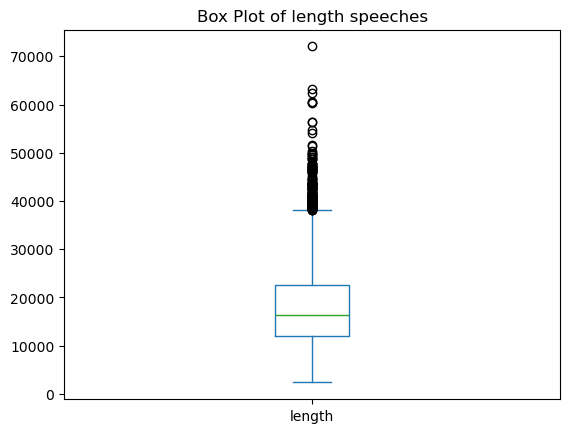

In [17]:
df['length'].plot(kind='box',title='Box Plot of length speeches') # option vert=False pour le mettre à l'horizontale

<Axes: title={'center': 'Histogram of variable length'}, ylabel='Frequency'>

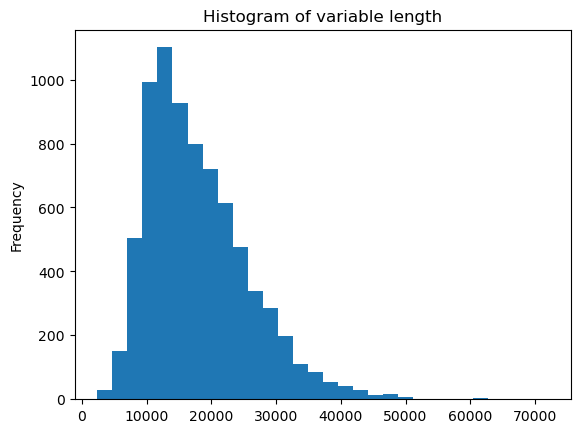

In [18]:
df['length'].plot(kind='hist',bins=30,title='Histogram of variable length') # bins=30 the numerical values are divided into 30 intervals of equal width

## Comparing values across categories

- Comparisons of the distribution of length speech across different categories of the data
- Visualisation with boxplot and violin 
- Seaborn's catplot

In [19]:
where = df['country'].isin(['USA','FRA','GBR'])

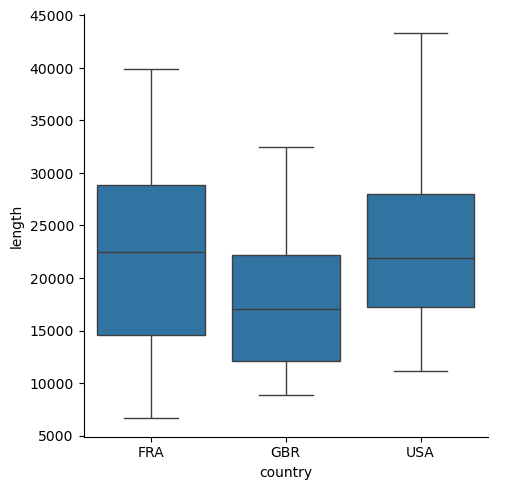

In [20]:
sns.catplot(data=df[where],x="country",y="length",kind="box")

- The violin plot is a "smoothed" version of the boxplot
- The frequencies are represented by the width of the violin body

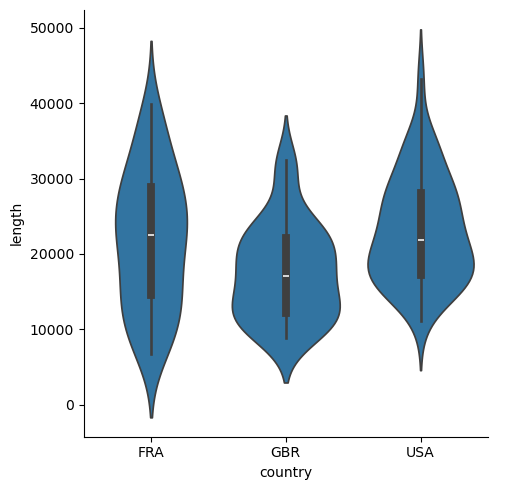

In [21]:
sns.catplot(data=df[where],x="country",y="length",kind="violin")

## Vizualizing Developments over time

- When data have date or time attributes 
- Example: representing the number of countries per year (one speech by country every year)


In [22]:
df.groupby('year').size()

year
1970     70
1971    116
1972    125
1973    120
1974    129
1975    126
1976    134
1977    140
1978    141
1979    144
1980    149
1981    145
1982    147
1983    149
1984    150
1985    137
1986    149
1987    152
1988    154
1989    153
1990    156
1991    162
1992    167
1993    175
1994    178
1995    172
1996    181
1997    176
1998    181
1999    181
2000    178
2001    189
2002    188
2003    189
2004    192
2005    185
2006    193
2007    191
2008    192
2009    193
2010    189
2011    194
2012    195
2013    193
2014    194
2015    193
dtype: int64

<Axes: title={'center': 'Number of countries'}, xlabel='year'>

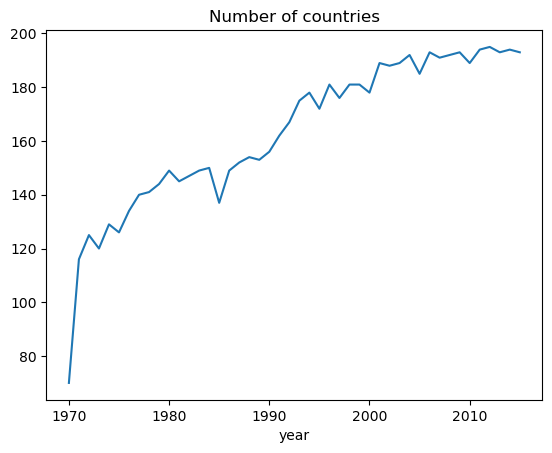

In [22]:
df.groupby('year').size().plot(title="Number of countries")

Computation of the average speech length by year

<Axes: title={'center': 'Avg. Speech Length'}, xlabel='year'>

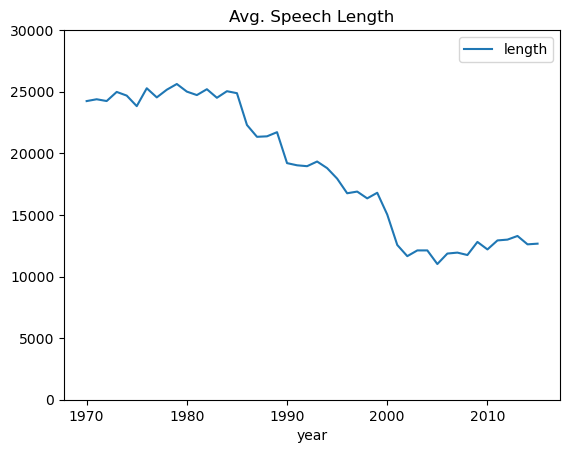

In [23]:
df.groupby('year').agg({"length":"mean"}).plot(title="Avg. Speech Length", ylim=(0,30000))

# Building a Simple Text Processing Pipeline

- Tranformation of the source text 
- Three steps:
    1. Case-folding into lowercase
    2. Tokenization
    3. Stop word removal
- Final output: **prepared tokens**

## Performing Tokenization

- Tokenization is the process of extracting words from a sequence of characters
- In Western languages, words are separated by space and punctuation most of the time
- We present a simple tokenizer based on regular expressions and show how to use an arbitrary stop words list
- We use Python libraries re and regex

In [23]:
import regex as re

#### Building a function which perform tokenization

In [24]:
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*',text)

In [25]:
test="For the meetings before 1994, the transcripts were produced from the original, raw transcripts in the FOMC Secretariat's files"
tokens=tokenize(test)
print("/".join(tokens))


For/the/meetings/before/the/transcripts/were/produced/from/the/original/raw/transcripts/in/the/FOMC/Secretariat/s/files


## Treating stop words
- The most frequent words are common words: auxiliary verbs, pronouns, adverbs, determiners ( a word that is used before a noun to show which particular example of the noun you are referring to),...
- These words are called **stop words**  
- not very informative about the content of a text, but very frequent
- stop words are therefore frequently removed from the text
- **stop words are removed according to a predefined list** 
- those lists are available for many languages
- we consider an example with **NLTK** list of stop words


In [39]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ylepen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
# Import stopwords from NLTK

stopwords=set(nltk.corpus.stopwords.words('english'))
print(stopwords)

{"mightn't", 'again', 'down', 'few', 'theirs', "we're", 'won', 'have', 'whom', 'same', "that'll", 'through', "you're", 'doesn', "doesn't", 'in', 'our', 'all', 'above', "mustn't", 'before', 'over', 'more', 'your', 'ours', 'then', 'haven', 'mightn', 'wouldn', 'her', 'myself', 'those', "i'm", "don't", 'yours', 'an', 'own', 'what', 'm', 'where', "won't", 'not', 'both', 'off', 'here', 'now', 'each', 're', "you'd", "we've", 'until', 'him', 'hasn', "weren't", 've', "we'd", 'yourselves', 'd', 'doing', 'of', 'to', 'am', "i'll", 'once', 'hadn', 'only', "she'd", 'will', 'very', 'did', 'been', 'after', "haven't", 'be', 'll', 'during', 'them', 'while', 'from', "shouldn't", 'ourselves', 'because', 'this', 'at', "aren't", 'any', 'nor', 'shan', 'these', "you've", 'so', 'on', 'that', 'didn', 'their', 'being', "i've", "isn't", 'y', 'just', 'mustn', "she'll", 'into', 'himself', 'o', 'had', 'is', 'shouldn', 'itself', 'they', 'herself', 'my', 'has', 'below', "should've", "couldn't", 'or', 'the', 'me', "he'

In [41]:
len(stopwords)

198

#### Comments
- not of a lot of stop words in this list
- some inconsistencies: "has" is not in the list but "hasn't" belongs to it
- be cautious when using stop words lists and check if they are in line with the objectives of the analysis

In [30]:
import spacy 
import en_core_web_sm
en = en_core_web_sm.load()

# Import stopword from spaCy
#import spacy 

# Import stopword from spaCy
#import spacy 
#loading the english language small model of spacy

stopwords_spa = en.Defaults.stop_words

print(len(stopwords_spa))
print(stopwords_spa)

326
{'again', 'in', 'above', 'seem', 'your', 'twelve', '’d', 'nowhere', 'then', 'whenever', 'her', 'thus', 'become', 'moreover', 'already', 'what', 're', 'ever', '’ll', 'very', 'be', 'while', 'became', 'ourselves', 'at', 'nor', 'these', 'thru', 'fifteen', 'done', 'serious', '’re', 'somehow', 'whole', 'last', 'my', 'sometimes', 'therefore', 'anyone', 'we', 'other', 'nobody', 'was', 'seems', 'else', 'everything', '‘ll', 'ten', '’ve', 'made', 'ca', 'further', 'sixty', 'becomes', 'towards', 'enough', 'thence', 'as', 'neither', 'twenty', 'must', 'used', 'n’t', 'third', 'most', '‘re', 'wherever', 'which', 'among', 'first', 'noone', 'onto', 'does', 'if', 'for', 'you', 'around', 'do', 'amongst', 'anyhow', 'whom', 'our', 'all', 'though', "'ve", 'whereas', 'could', 'ours', 'myself', 'yours', 'an', 'often', 'former', 'alone', 'off', 'eleven', 'back', 'now', '‘s', 'him', 'doing', 'to', 'am', 'except', 'will', 'someone', 'everyone', 'from', 'sometime', 'toward', 'mostly', 'seemed', 'call', 'somethi

#### Inclusion of domain-specific stop words

- We can add domain-specific stop word to a predefined list with operator union/or |
- We can exclude some specific stop word from a list with operator difference -

In [31]:
include_stopwords={'dear','regards','must','would','also'}
exclude_stopwords={'against'}

stopwords_spa |= include_stopwords
stopwords_spa -= exclude_stopwords


#### Other options to set a list of stop words
- remove words with a frequency above a given percentage

#### A function to remove stopwords

In [32]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

## Processing a Pipeline with one line of code

- We add a new column called **tokens** to the DataFrame containing the documents.
- This column will contain lowercase, tokenized text, without stop words
- We build a processing pipeline which implement all these tasks

In [42]:
pipeline = [str.lower,tokenize,remove_stop]

In [43]:
def prepare(text,pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

- Utilization of the functions **apply** and **map**
- Series.map : works element by element on a Pandas Series
- Series.apply : same as map but allows additional parameters
- DataFrame.applymap : element by element on a Pandas DataFrame (same as map on Series)
- DataFrame.apply : works on rows and columns of a DataFrame and supports aggregation

In [44]:
df['tokens']=df['text'].apply(prepare,pipeline=pipeline)

In [45]:
df['tokens'].sample(2)

3540    [wish, first, express, satisfaction, election,...
1953    [sincere, deep-felt, emotion, jordan, shares, ...
Name: tokens, dtype: object

In [37]:
df['num_tokens']=df['tokens'].map(len)
df['num_tokens'].sample(3)

7456    1200
1132    1217
3599    1348
Name: num_tokens, dtype: int64

# Word Frequency Analysis: Bag-of-words approach
- A first analysis of texts **based on words or phrases frequently used**
- can be useful to uncover the main topics discussed in documents
- limits of word frequency analysis:
    - the order of words is not taken into account
    - the context is ignored
    - **bag-of-words** model: all words are put into a bag
- **bag-of-words** is fit for:
    - classification
    - topic modeling
- **bag-of-words** doesn\'t work well for:
    - sentiment analysis
    - question answering



## Counting words with a counter

In [38]:
from collections import Counter
counter = Counter(df['tokens'][1])
print(counter)

Counter({'united': 24, 'nations': 23, 'international': 15, 'development': 14, 'assembly': 13, 'year': 12, 'states': 11, 'finland': 11, 'countries': 11, 'general': 10, 'global': 10, 'peace-keeping': 10, 'world': 9, 'also': 8, 'organization': 8, 'new': 8, 'developing': 8, 'problems': 8, 'security': 7, 'co-operation': 7, 'environment': 7, 'session': 6, 'role': 6, 'member': 6, 'possible': 6, 'order': 6, 'challenges': 6, 'help': 6, 'must': 6, 'time': 6, 'respect': 6, 'process': 6, 'conference': 6, 'already': 6, 'special': 6, 'strategy': 6, 'national': 6, 'population': 6, 'part': 5, 'present': 5, 'major': 5, 'level': 5, 'finnish': 5, 'requires': 5, 'confidence': 5, 'soon': 5, 'activities': 5, 'protection': 5, 'operations': 5, 'namibia': 5, 'may': 4, 'secretary-general': 4, 'emphasize': 4, 'particularly': 4, 'poverty': 4, 'peace': 4, 'efforts': 4, 'course': 4, 'preparation': 4, 'could': 4, 'take': 4, 'human': 4, 'therefore': 4, 'economic': 4, 'resources': 4, 'increasing': 4, 'would': 4, 'fiel

In [46]:
counter.most_common(3)

[('united', 24), ('nations', 23), ('international', 15)]

### Updating a counter

In [40]:
counter.update(df['tokens'][2])
print(counter)

Counter({'international': 49, 'countries': 46, 'united': 40, 'nations': 36, 'development': 31, 'world': 27, 'must': 27, 'peace': 27, 'niger': 25, 'general': 24, 'assembly': 24, 'new': 22, 'economic': 22, 'organization': 21, 'states': 20, 'efforts': 20, 'developing': 19, 'community': 19, 'security': 17, 'political': 17, 'two': 16, 'year': 16, 'conference': 16, 'support': 15, 'people': 14, 'co-operation': 14, 'national': 14, 'session': 12, 'also': 12, 'time': 12, 'africa': 12, 'south': 12, 'secretary-general': 11, 'finland': 11, 'respect': 11, 'process': 11, 'many': 11, 'peoples': 11, 'social': 11, 'problems': 11, 'environment': 11, 'make': 11, 'made': 11, 'african': 11, 'president': 10, 'member': 10, 'possible': 10, 'order': 10, 'global': 10, 'action': 10, 'peace-keeping': 10, 'still': 10, 'state': 9, 'country': 9, 'work': 9, 'special': 9, 'protection': 9, 'parties': 9, 'situation': 9, 'challenges': 8, 'progress': 8, 'last': 8, 'help': 8, 'particularly': 8, 'present': 8, 'us': 8, 'hope'

### Counting the words frequency for a corpus of documents
- Option 1: merging all texts into a single one. But too long for large datasets
- Option 2: call update function of the counter object for each single document

In [47]:
counter = Counter()
df['tokens'].map(counter.update)
len(counter)

68398

In [48]:
counter

Counter({'nations': 124508,
         'united': 120763,
         'international': 117223,
         'world': 89421,
         'countries': 85734,
         'peace': 72625,
         'development': 62632,
         'states': 59713,
         'people': 59338,
         'security': 58425,
         'economic': 53833,
         'must': 51880,
         'also': 47403,
         'new': 44453,
         'country': 40878,
         'assembly': 40413,
         'community': 38294,
         'government': 37430,
         'general': 37138,
         'organization': 36434,
         'human': 36384,
         'would': 35936,
         'efforts': 35184,
         'us': 34618,
         'rights': 33495,
         'political': 33353,
         'one': 31840,
         'africa': 31293,
         'support': 30224,
         'council': 29573,
         'session': 29391,
         'developing': 25977,
         'peoples': 25161,
         'time': 24870,
         'order': 23581,
         'republic': 23369,
         'national': 23221,
   

In [41]:
type(counter)

collections.Counter

### Finding the most common words in a text

In [49]:
print(counter.most_common(5))

[('nations', 124508), ('united', 120763), ('international', 117223), ('world', 89421), ('countries', 85734)]


### Transforming the counter into a DataFrame

In [44]:
def count_words(df,column='tokens',preprocess=None,min_freq=2):
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    
    # create counter and run through all data
    counter = Counter()
    df[column].map(update)
    
    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter,orient='index',columns=['freq'])
    freq_df=freq_df.query('freq>=@min_freq')
    freq_df.index.name='token'
    
    return freq_df.sort_values('freq',ascending=False)
    

In [45]:
freq_df=count_words(df)

In [46]:
freq_df.head(10)

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734
peace,72625
development,62632
states,59713
people,59338


### Creating a Frequency Diagram

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

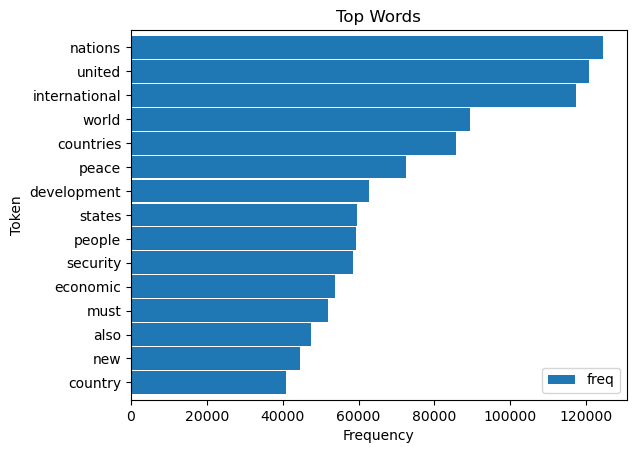

In [47]:
ax=freq_df.head(15).plot(kind='barh',width=0.95)
ax.invert_yaxis()
ax.set(xlabel='Frequency',ylabel='Token',title='Top Words')

### Creating Word Clouds

In [48]:
from wordcloud import WordCloud

In [49]:
text = df.query("year==2015 and country=='USA'")['text'].values[0]

print(text)

Seventy years after the founding of the United Nations it is worth reflecting on what the members of this body, working together, have helped to achieve. Out of the ashes of the Second World War, having witnessed the unthinkable power of the atomic age, the United States has worked with many nations in the Assembly to prevent a third world war — by forging alliances with old adversaries; by supporting the steady emergence of strong democracies accountable to their people and not to any foreign Power; and by building an international system that imposes a cost on those who choose conflict over cooperation, an order that recognizes the dignity and equal worth of all people.
That has been the work of seven decades. That is the ideal that this body has, at its best, pursued. Of course, there have been too many times when, collectively, we have fallen short of those ideals. Over the seven decades, terrible conflicts have claimed untold victims. But we have pressed forward, slowly, steadily,

#### WordCloud for a single text

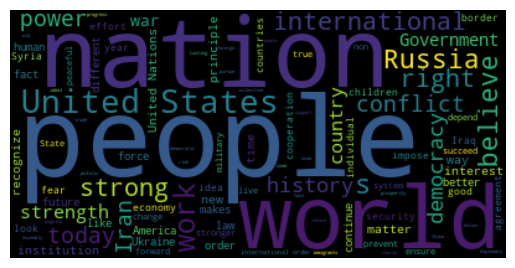

In [50]:
wc = WordCloud(max_words=100,stopwords=stopwords_spa)
wc.generate(text)
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()

#### WordCloud for a corpus of documents

In [51]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    
    wc = WordCloud(width=800,height=400,
                  background_color='black',colormap='Paired',
                  max_font_size=130,max_words=max_words)
    
    # Convert DataFrame into dict
    if type(word_freq)==pd.Series:
        counter=Counter(word_freq.fillna(0).to_dict())
    else:
        counter=word_freq
        
    #filter stop words in frequency counter
    if stopwords is not None:
        counter={token:freq for (token,freq) in counter.items() if token not in stopwords}
    wc.generate_from_frequencies(counter)
    
    plt.title(title)
    
    plt.imshow(wc,interpolation='bilinear')
    plt.axis('off')

In [52]:
freq_2015_df=count_words(df[df['year']==2015])

In [53]:
freq_2015_df
type(freq_2015_df['freq'])

pandas.core.series.Series

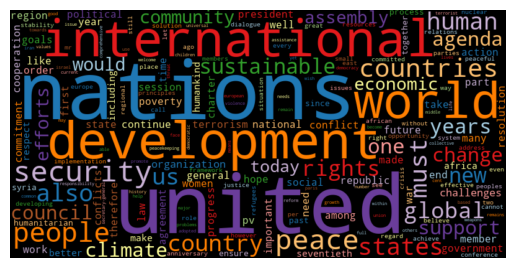

In [54]:
plt.figure()
wordcloud(freq_2015_df['freq'],max_words=200)

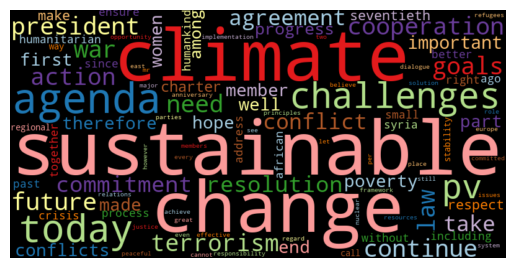

In [55]:
wordcloud(freq_2015_df['freq'],max_words=100,stopwords=freq_df.head(50).index)

# Ranking with TF-IDF

- Visualization of words frequencies is not very informative
- Most frequent words are often domain-specific and similar for differents slices (subsets) of data
- Alternative approach: **to give more importance to words that appear more frequently in a given subset of the data (a single speech, speeches of a country, speeches for a given year) than on average**
- Combination of
    - the term frequency
    - the inverse document frequency

- **Document frequency** of term *t* 
    - a corpus of documents *C*
    - document frequency: the number of documents *d* that contains the term *t*:
    $$
    df(t)=|\lbrace d   \in C|t \in d \rbrace|
    $$
    - Terms that appear in many documents have a high document frequency


- **Inverse document frequency**: a weighting scheme that measures the "unusualness" of a term in a corpus often used to reduce the influence of common terms for data analysis
- - **Inverse document frequency** is defined as:
    $$
    idf(t)=log(\frac{|C|}{df(t)})
    $$
    - in log to avoid a too large value for rare terms
    - $idf(t)=0$ for terms that appear in all documents ($df(t)=0$)
    - Some libraries add a constant to the whole term for not completely ignoring this term
    - scikit-learn adds +1
    - alternative option: to add +1 to the denominator to prevent a division by zero dor unseen terms with $df(t)=0$ (*smoothing*)
    
- For a word *t* in a set of documents $D \subset C$, the TF-IDF-score is the product of 
    - the term frequency $tf(t,D)$
    - the IDF of temr *t*:
        $$
        tfidf(t,D)=tf(t,D).idf(t)
        $$

- $tfidf(t,D)$ gives high value for terms:
    - appearing frequently in the selected documents D,
    - rarely in the other documents of the corpus

In [56]:
print(df['tokens'][1])

['may', 'begin', 'congratulating', 'sir', 'election', 'presidency', 'general', 'assembly', 'forty-fourth', 'session', 'wide', 'experience', 'united', 'nations', 'makes', 'especially', 'qualified', 'guide', 'assembly', 'deliberations', 'best', 'wishes', 'demanding', 'task', 'lies', 'ahead', 'may', 'also', 'express', 'thanks', 'outgoing', 'president', 'mr', 'dante', 'caputo', 'ably', 'fulfilled', 'role', 'behalf', 'assembly', 'gives', 'particular', 'pleasure', 'pay', 'tribute', 'secretary-general', 'owe', 'great', 'deal', 'authority', 'leadership', 'assembled', 'annual', 'general', 'debate', 'every', 'member', 'state', 'needs', 'reflect', 'certain', 'fundamental', 'questions', 'united', 'nations', 'everything', 'possible', 'order', 'meet', 'challenges', 'making', 'progress', 'say', 'united', 'nations', 'enters', 'last', 'decade', 'century', 'determination', 'justified', 'self-confidence', 'country', 'everything', 'order', 'help', 'world', 'organization', 'answers', 'questions', 'must', '

In [56]:
set (df['tokens'][1])

{'-consolidating',
 '-insecurity',
 '1990s',
 'ably',
 'absence',
 'accept',
 'according',
 'account',
 'accumulated',
 'achieve',
 'achievements',
 'achieving',
 'acid',
 'action',
 'actively',
 'activities',
 'activity',
 'actual',
 'added',
 'addition',
 'address',
 'adopted',
 'advances',
 'affect',
 'affected',
 'agencies',
 'agenda',
 'ago',
 'agreed',
 'agreeing',
 'ahead',
 'aid',
 'almost',
 'already',
 'also',
 'ambitious',
 'american',
 'annual',
 'answer',
 'answers',
 'apparent',
 'applied',
 'appropriate',
 'arab',
 'area',
 'areas',
 'armaments',
 'aspects',
 'assembled',
 'assembly',
 'assessed',
 'assistance',
 'atmosphere',
 'atmospheric',
 'attention',
 'authority',
 'available',
 'avenues',
 'awarded',
 'awareness',
 'back',
 'balance',
 'basic',
 'basis',
 'battalion',
 'battalions',
 'become',
 'begin',
 'beginnings',
 'behalf',
 'believe',
 'best',
 'beyond',
 'big',
 'biggest',
 'bilateral',
 'billion',
 'binding',
 'borne',
 'boundaries',
 'bring',
 'broader',


### A function to compute the IDF for all terms in the corpus

In [57]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):
   
    def update(doc):
        tokens=doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))
        
    # count tokens 
    counter = Counter()
    df[column].map(update)
    
    # create DataFrame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index',columns=['df'])
    #idf_df['idf']=np.log(len(df)/(1+idf_df['df']))
    idf_df['idf']=np.log(len(df)/idf_df['df'])+1
    idf_df.index.name='token'
    idf_df = idf_df.query('df>=@min_df')
    
    return idf_df

**The IDF needs to be computed for the entire corpus of texts**

In [58]:
idf_df=compute_idf(df,min_df=0)

In [59]:
idf_df.head()

,df,idf
token,,
deal,2749,2.004599
recent,5173,1.372383
planet,1997,2.324190
opportunity,5029,1.400615
sharing,665,3.423804


In [60]:
idf_df.index

Index(['deal', 'recent', 'planet', 'opportunity', 'sharing', 'delicacy', 'may',
       'improved', 'defence', 'congratulations',
       ...
       'tetovo', 'nla', 'legitimatization', 'ex-wives', 'pre-world',
       'démocratie-forces', 'press-gang', 'anthrax-related',
       'multi-concessional', 'stone-throwing'],
      dtype='object', name='token', length=68398)

In [61]:
freq_df.index

Index(['nations', 'united', 'international', 'world', 'countries', 'peace',
       'development', 'states', 'people', 'security',
       ...
       'all-sided', 'seconding', 'hounds', 'well-chosen', 'terror-ism', 'tp',
       'van-guard', 'magnetic', 'composers', 'output-'],
      dtype='object', name='token', length=40512)

freq_df and idf_df have the *same* index => we can simply use the multiplication to compute the tidf

In [62]:
freq_df['tidf']=freq_df['freq']*idf_df['idf']

In [63]:
freq_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40512 entries, nations to output-
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   freq    40512 non-null  int64  
 1   tidf    40512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.9+ MB


In [64]:
freq_df.head(10)

,freq,tidf
token,,
nations,124508,124707.186284
united,120763,120972.308632
international,117223,117864.976226
world,89421,89982.608982
countries,85734,88049.085986
peace,72625,74457.008519
development,62632,65134.208844
states,59713,62115.151323
people,59338,62295.588053


## Comparison of wordcloud based on 
* word counts (term frequency)
* TF_IDF scores

for year 1970 and year 2015

### First step: computation of word frequencies for these two years

In [65]:
freq_1970 = count_words(df[df['year']==1970])
freq_2015 = count_words(df[df['year']==2015])

### Second step: computation of tf_idf

In [66]:
freq_1970['tfidf']=freq_1970['freq']*idf_df['idf']
freq_2015['tfidf']=freq_2015['freq']*idf_df['idf']

### Word cloud based on word frequencies

We add 'twenty-fifth' and 'twenty-five' as stopwords. 1970 is the 25th session

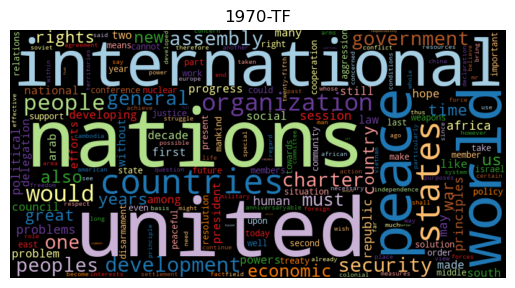

In [67]:
#wordcloud(freq_1970['freq'],title='1970-TF',stopwords=['twenty-fifth','twenty-five'])
wordcloud(freq_1970['freq'],title='1970-TF')

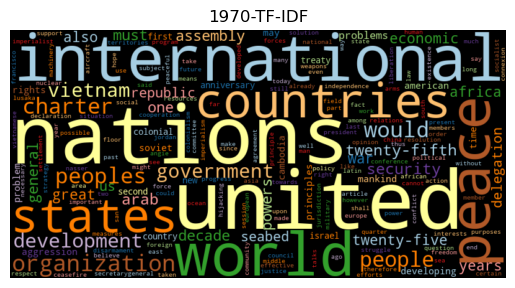

In [68]:
wordcloud(freq_1970['tfidf'],title='1970-TF-IDF')

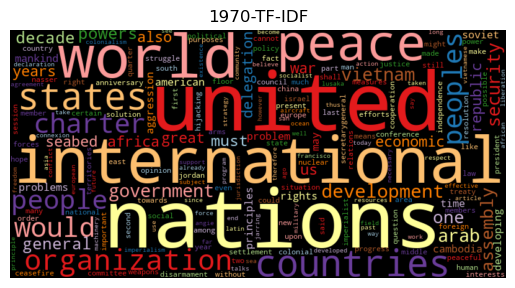

In [69]:
wordcloud(freq_1970['tfidf'],title='1970-TF-IDF',stopwords=['twenty-fifth','twenty-five','twenty','fifth'])

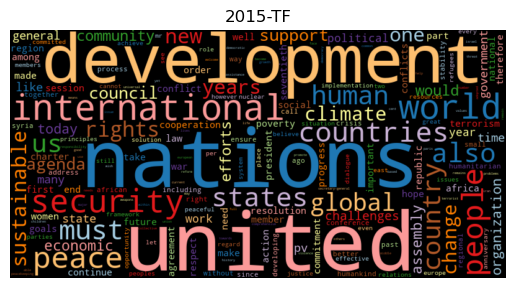

In [70]:
wordcloud(freq_2015['freq'],title='2015-TF')

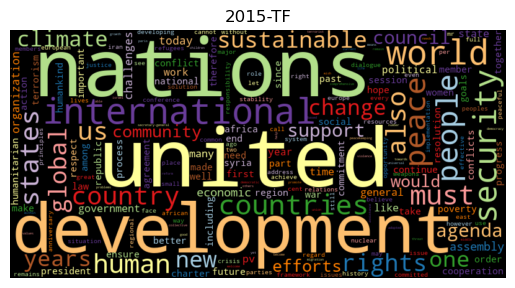

In [71]:
wordcloud(freq_2015['freq'],title='2015-TF',stopwords=['seventieth'])

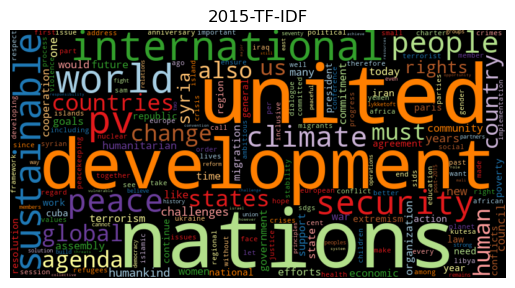

In [72]:
wordcloud(freq_2015['tfidf'],title='2015-TF-IDF',stopwords=['seventieth'])

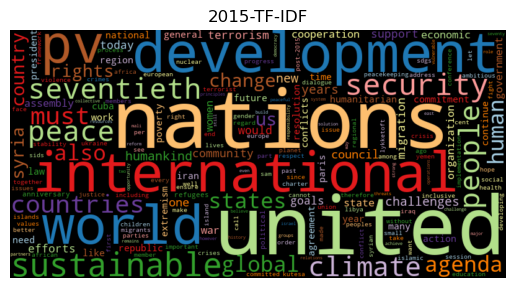

In [73]:
wordcloud(freq_2015['tfidf'],title='2015-TF-IDF')

scikit-learn classes:
    
    - CountVectorizer
    - TfidfVectorizer

In [74]:
##  Same thing with country and a year

# Finding a keyword in context

- Not always easy to interpret some frequent words (acronym for instance)
- Exploration of the way those words appear in the unprepared text: inspection of the **keywords in context** (KWIC)
- Produce a list of text fragments of equal length showing the left and right context of a keyword

- KWIC is implemented in NLTK and textacy
- NLTK and textacy work on single document
- Textacy'KWIC' works on untokenized text and multiple tokens (not possible with NLTK (à vérifier))


In [74]:
text_tokens = df.query("year==2015 and country=='USA'")['tokens'].values[0]

print(text_tokens)

['seventy', 'years', 'founding', 'united', 'nations', 'worth', 'reflecting', 'members', 'body', 'working', 'together', 'helped', 'achieve', 'ashes', 'second', 'world', 'war', 'witnessed', 'unthinkable', 'power', 'atomic', 'age', 'united', 'states', 'worked', 'many', 'nations', 'assembly', 'prevent', 'third', 'world', 'war', 'forging', 'alliances', 'old', 'adversaries', 'supporting', 'steady', 'emergence', 'strong', 'democracies', 'accountable', 'people', 'foreign', 'power', 'building', 'international', 'system', 'imposes', 'cost', 'choose', 'conflict', 'cooperation', 'order', 'recognizes', 'dignity', 'equal', 'worth', 'people', 'work', 'seven', 'decades', 'ideal', 'body', 'best', 'pursued', 'course', 'many', 'times', 'collectively', 'fallen', 'short', 'ideals', 'seven', 'decades', 'terrible', 'conflicts', 'claimed', 'untold', 'victims', 'pressed', 'forward', 'slowly', 'steadily', 'make', 'system', 'international', 'rules', 'norms', 'better', 'stronger', 'consistent', 'international', '

In [75]:
from nltk.text import Text

In [76]:
text_token=Text(text_tokens)
text_token.concordance(["people"],width=80)

Displaying 25 of 38 matches:
gence strong democracies accountable people foreign power building international
order recognizes dignity equal worth people work seven decades ideal body best p
ressed global economy lifted billion people poverty international principles hel
igrants ominously see fears ordinary people exploited appeals sectarianism triba
poses corruption raises expectations people around globe technology social media
logy social media irreducible desire people everywhere make choices governed ind
als strength nations depends success people knowledge innovation imagination cre
t upon us yet look results ukrainian people interested ever aligning europe inst
ba policy failed improve lives cuban people changed continue differences cuban g
on support reforms better life cuban people deserve believe cuba find success pu
 iran promise trade commerce iranian people proud history filled extraordinary p
th good security region good iranian people good world course around globe conti

In [77]:
text_token=Text(text_tokens)
text_token.concordance(["people","poverty"],width=80)

Displaying 2 of 2 matches:
ed global economy lifted billion people poverty international principles helped 
on put skies help economies lift people poverty without condemning children rava


In [78]:
text_token.collocation_list()

[('united', 'states'),
 ('major', 'powers'),
 ('united', 'nations'),
 ('international', 'order'),
 ('strong', 'enough'),
 ('non-governmental', 'organizations'),
 ('share', 'common'),
 ('civil', 'society'),
 ('seven', 'decades'),
 ('tens', 'thousands'),
 ('international', 'system'),
 ('around', 'globe'),
 ('could', 'things'),
 ('control', 'territory'),
 ('men', 'women'),
 ('cold', 'war'),
 ('roll', 'back'),
 ('new', 'capabilities'),
 ('ever', 'known'),
 ('old', 'ways')]

In [79]:
text_token.collocation_list()[:3]

[('united', 'states'), ('major', 'powers'), ('united', 'nations')]

# Analysing N-grams

- Extension of frequency analysis to short sequences of two or three words
- two types of word sequences:
    1. **compound**
    2. **collocations**

- A **compound** is a combination of two or more more words with a specific meaning:
    - in closed form: *earthquake*
    - in hyphenated form: *self-confident*
    - in open form: *climate change*

- Consequence: two tokens are to be considered as a *single* unit

        

- A **colocation** are words that are frequently used together
    - adjective+noun, adjective+noun: *red carpet*, *united nations*


- *unigrams*: a sequence of length 1
- *bigrams*: a sequence of length 2
- *trigrams*: a sequence of length 3
   

### Function to produce n-grams

In [80]:
def ngrams(tokens,n=2,sep=' '):
    return[sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [81]:
text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print(ngrams(tokens,2))

['the visible', 'visible manifestation', 'manifestation of', 'of the', 'the global', 'global climate', 'climate change']


In [82]:
print("|".join(ngrams(tokens,2,sep='')))

thevisible|visiblemanifestation|manifestationof|ofthe|theglobal|globalclimate|climatechange


In [83]:
text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print(tokens)

['the', 'visible', 'manifestation', 'of', 'the', 'global', 'climate', 'change']


In [84]:
n=2
ngram= zip(*[tokens[i:] for i in range(n)])
list(ngram)

[('the', 'visible'),
 ('visible', 'manifestation'),
 ('manifestation', 'of'),
 ('of', 'the'),
 ('the', 'global'),
 ('global', 'climate'),
 ('climate', 'change')]

In [85]:
for i in range(2):
    print(i)

0
1


In [86]:
tokens[0:]

['the', 'visible', 'manifestation', 'of', 'the', 'global', 'climate', 'change']

In [87]:
tokens[1:]

['visible', 'manifestation', 'of', 'the', 'global', 'climate', 'change']

In [88]:
n=2
a= zip(*[tokens[i:] for i in range(n)])
print(list(a))

[('the', 'visible'), ('visible', 'manifestation'), ('manifestation', 'of'), ('of', 'the'), ('the', 'global'), ('global', 'climate'), ('climate', 'change')]


In [89]:
bigram=ngrams(tokens)
print(bigram)

['the visible', 'visible manifestation', 'manifestation of', 'of the', 'the global', 'global climate', 'climate change']


- Problem: the bigrams contain stop words
- better to build bigrams without stop words
- if we eliminate stop words from the original text => risk to obtain erroneous bigrams
- solution to avoid this problem:
    1. to compute all bigrams for the text, even those with stop words
    2. to eliminate bigrams with stop words

In [90]:
def ngrams(tokens,n=2,sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)]) if len([t for t in ngram if t in stopwords])==0]

In [91]:
text = "the visible manifestation of the global climate change"
tokens = tokenize(text)

In [92]:
print("|".join(ngrams(tokens,2,stopwords=stopwords_spa)))


visible manifestation|global climate|climate change


Bigrams for the whole set of speeches

In [93]:
df['bigrams']=df['text'].apply(prepare,pipeline=[str.lower,tokenize]).apply(ngrams,n=2,stopwords=stopwords_spa)

In [94]:
df['bigrams_1']=df['tokens'].apply(ngrams,n=2,stopwords=stopwords_spa)

In [95]:
df['bigrams_1'].head(5)

0    [pleasure members, members delegation, delegat...
1    [begin congratulating, congratulating sir, sir...
2    [mr president, president particular, particula...
3    [debate fortieth, fortieth session, session ge...
4    [like outset, outset express, express delegati...
Name: bigrams_1, dtype: object

In [96]:
count_words(df,'bigrams_1').head(5)

,freq
token,
united nations,103244
international community,27786
general assembly,27101
security council,20972
human rights,19864


#### Computation of the TF-IDF for the bigrams

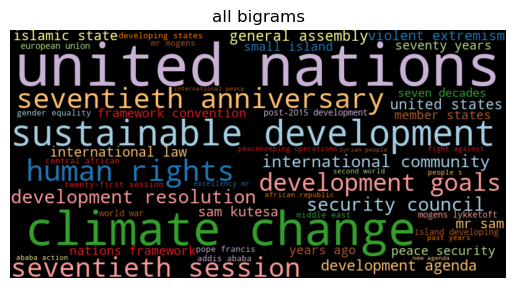

In [97]:
idf_df=pd.concat([idf_df,compute_idf(df,'bigrams',min_df=10)])

freq_df = count_words(df[df['year']==2015],'bigrams')
freq_df['tidf']=freq_df['freq']*idf_df['idf']
wordcloud(freq_df['tidf'],title = 'all bigrams',max_words=50)

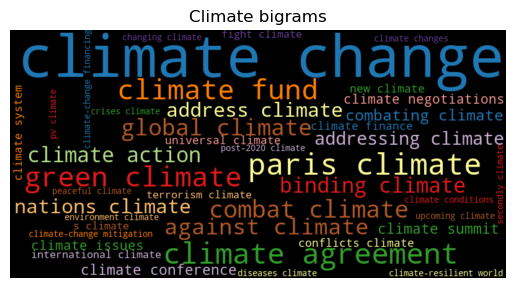

In [98]:
where= freq_df.index.str.contains('climate')
wordcloud(freq_df[where]['freq'],title = 'Climate bigrams',max_words=50)

# Comparing Frequencies across time intervals and categories

- We can define a set of keywords
- We can measure the frequency of these keywords over time

#### Counting a set of given keywords

In [99]:
def count_keywords(tokens,keywords):
    tokens =[t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k,0) for k in keywords]

In [100]:
keywords=['nuclear','terrorism','climate','freedom']
tokens=['nuclear','climate','climate','freedom','climate','freedom']
print(count_keywords(tokens,keywords))

[1, 0, 3, 2]


- If we apply this function to each of our documents in our DataFrame, we obtain a matrix of counts
- The matrix is then converted into a DataFrame and aggregated and sorted by the selected grouping column

In [101]:
def count_keywords_by(df,by,keywords,column='tokens'):
    freq_matrix=df[column].apply(count_keywords,keywords=keywords)
    freq_df=pd.DataFrame.from_records(freq_matrix,columns=keywords)
    freq_df[by]=df[by]
    
    return freq_df.groupby(by=by).sum().sort_values(by)

In [102]:
freq_df=count_keywords_by(df,by='year',keywords=keywords)

In [103]:
print(freq_df)

      nuclear  terrorism  climate  freedom
year                                      
1970      192          7       18      128
1971      275          9       35      205
1972      393        379       74      280
1973      347        124       79      266
1974      478         24       71      316
1975      578         20       53      232
1976      451        146       57      347
1977      675         75       58      321
1978      550         82       52      309
1979      492         40       81      366
1980      613         47      105      350
1981      717         96      122      349
1982      657         83      119      280
1983      776         42      112      354
1984      890        113      115      314
1985      809        144      104      301
1986      807        356      103      270
1987      652        154      102      302
1988      562        112      222      236
1989      399        156      287      282
1990      269         51      177      297
1991      3

<Axes: xlabel='year'>

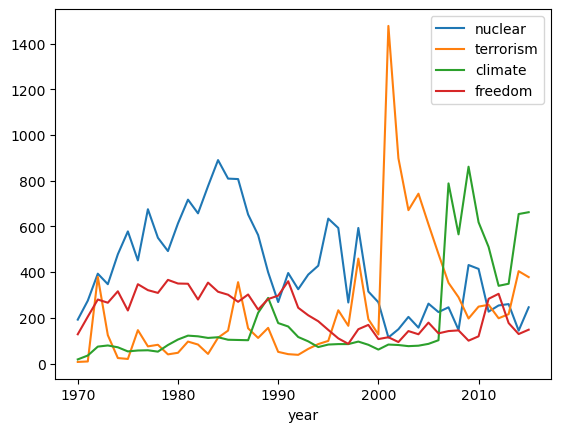

In [104]:
freq_df.plot(kind='line')

#### Creating frequency heatmaps

In [105]:
# Computation of relative frequencies
freq_df=freq_df.div(df.groupby('year')['num_tokens'].sum(),axis=0)
freq_df=freq_df.apply(np.sqrt) # sublinear scaling

<Axes: xlabel='year'>

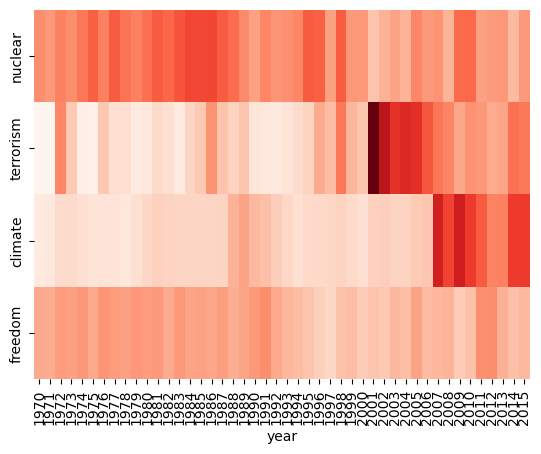

In [106]:
sns.heatmap(data=freq_df.T, xticklabels=True, yticklabels=True,cbar=False,cmap="Reds")

In [107]:
### Remarks:
- relative frequencies are more informative than absolute as the number of documents can vary each year
- keywords lists do not represent all the dimensions of a topic. Other words representative of a topic may be excluded from the keywords list.
- some keywords may have different meanings according to the context
- 

SyntaxError: invalid syntax (2265105217.py, line 2)